## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st

plt.rcParams.update({'font.size': 16})

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [2]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

In [3]:
len(hr_filenames)

1537

In [4]:
hr_filenames[0]

'/data/crisdb/e190a.npz'

In [5]:
subject = hr_filenames[0].split('/')[-1].split('.')[0]
subject

'e190a'

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [6]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(metadata_filename)

In [7]:
metadata.head()

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [8]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = filename.split('/')[-1].split('.')[0]

    # Find the age group for this subject in metadata.
    age_group = metadata['age'].loc[metadata['subject'] == subject].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata['sex'].loc[metadata['subject'] == subject].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [9]:
df.head()

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


#### Plot Resting Heart Rate vs. Age Group

In [11]:
labels = sorted(np.unique(df.age_group))
age = df['age_group'].value_counts()
sex = df['sex'].value_counts()

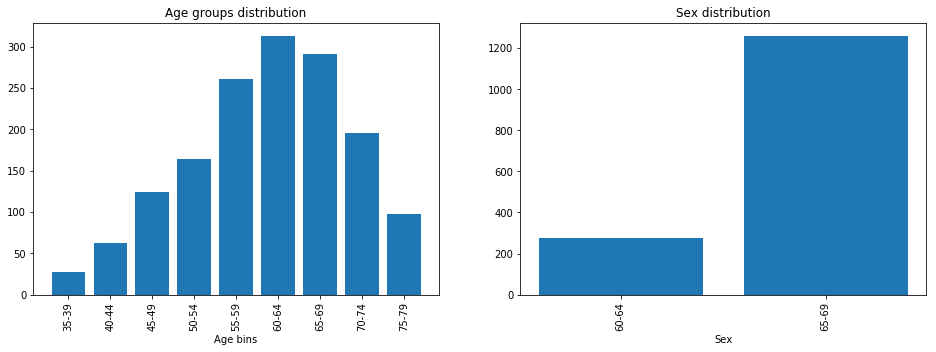

In [12]:
fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax.flatten()
ax[0].bar(age.index, age)
ax[0].set_title('Age groups distribution')
ax[0].set_xticklabels(labels, rotation=90)
ax[0].set_xlabel('Age bins')
ax[1].bar(sex.index, sex)
ax[1].set_title('Sex distribution')
ax[1].set_xticklabels(age.index, rotation=90)
ax[1].set_xlabel('Sex')
plt.show()

In [13]:
df_male = df[df.sex == 'Male']
df_male.shape

(1260, 3)

In [14]:
df_female = df[df.sex == 'Female']
df_female.shape

(277, 3)

In [15]:
male_rhr = df_male['rhr'].values
female_rhr = df_female['rhr'].values

male_mean = []
male_CI = []

female_mean = []
female_CI = []

for age_bin in labels:
    male_df_bin = df_male[df_male.age_group == age_bin]
    male_mean_bin = male_df_bin.rhr.mean()
    male_CI_bin = st.norm.interval(alpha=0.95, loc=male_df_bin.rhr.mean(), scale=st.sem(male_rhr))
    
    male_mean.append(male_mean_bin)
    male_CI.append(male_CI_bin[1] - male_CI_bin[0])
    
    
    female_df_bin = df_female[df_female.age_group == age_bin]
    female_mean_bin = female_df_bin.rhr.mean()
    female_CI_bin = st.norm.interval(alpha=0.95, loc=female_df_bin.rhr.mean(), scale=st.sem(female_rhr))
    
    female_mean.append(female_mean_bin)
    female_CI.append(female_CI_bin[1] - female_CI_bin[0])
    

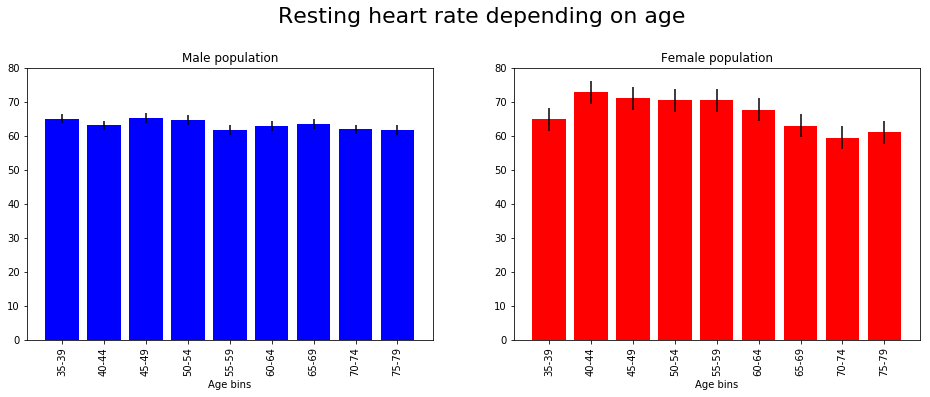

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16, 5))
fig.suptitle("Resting heart rate depending on age", fontsize=22, y = 1.05, x = 0.52)
ax.flatten()
ax[0].bar(labels, male_mean, yerr = male_CI, color='blue')
ax[0].set_title('Male population')
ax[0].set_ylim(0,80)
ax[0].set_xticklabels(labels, rotation=90)
ax[0].set_xlabel('Age bins')
ax[1].bar(labels, female_mean, yerr = female_CI, color='red')
ax[1].set_title('Female population')
ax[1].set_ylim(0,80)
ax[1].set_xticklabels(labels, rotation=90)
ax[1].set_xlabel('Age bins')
plt.show()

### Clinical Conclusion

1. Women have the highest resting heart rate (RHR) at the age 40-44, afterwards RHR decreases with age, with a slight rise at the age of 75-79. 
2. For men the general trend is that RHR decreses slightly with age.
3. Women have generally higher RHR. Moreover the RHR of females varies more with the age than RHR of males. 
4. The variation descibed in the previous point can be attributed to much lower female population enclosed in the studies (277 female participants vs 1260 male participants).
5. To make the results more trustworthy the dataset should be balanced with respect to age groups and sex. Moreover, the dataset represents population of people, who experienced in the past myocardial infraction. To see the trends in changes of RHR with age and depending on the sex, healthy population should be studied including also younger subjects.
6. The trend that the average RHR increases up until middle age and then decreases is not validated with the current dataset. It lacks data from younger subjects and should be balanced with respect to the age and sex.
